In [1]:
import sklearn.model_selection
import sklearn.preprocessing
import sklearn.preprocessing
import sklearn.linear_model
import sklearn.pipeline
import sklearn.datasets
import sklearn.metrics
import matplotlib.pyplot as plt
import numpy as np
import math
import os

# to make this notebook's output stable across runs
np.random.seed(42)

## 4.2 梯度下降
梯度下降是一种非常通用的优化算法，它能够很好地解决一系列问题。梯度下降的整体思路是通过的迭代来逐渐调整参数使得损失函数达到最小值。

假设浓雾下，你迷失在了大山中，你只能感受到自己脚下的坡度。为了最快到达山底，一个最好的方法就是沿着坡度最陡的地方下山。这其实就是梯度下降所做的：它计算误差函数关于参数向量$\theta$的局部梯度，同时它沿着梯度下降的方向进行下一次迭代。当梯度值为零的时候，就达到了误差函数最小值 。

具体来说，开始时，需要选定一个随机的$\theta$(这个值称为`随机初始值`)，然后逐渐去改进它，每一次变化一小步，每一步都试着降低损失函数(例如：均方差损失函数$MSE$)，直到算法收敛到一个最小值(如`图4-3`)。

<img src="images/04_03.png" style="width:500px;"/>

在梯度下降中一个重要的参数是`步长`，`超参数学习率`的值决定了步长的大小。如果学习率太小，必须经过多次迭代，算法才能收敛，这是非常耗时的(如`图4-4`)。

<img src="images/04_04.png" style="width:500px;"/>

另一方面，如果学习率太大，你将跳过最低点，到达山谷的另一面，可能下一次的值比上一次还要大。这可能使的算法是发散的，函数值变得越来越大，永远不可能找到一个好的答案(如`图4-5`)。

<img src="images/04_05.png" style="width:500px;"/>

最后，并不是所有的损失函数看起来都像一个规则的碗。它们可能是洞、山脊、高原和各种不规则的地形，使它们收敛到最小值非常的困难。 `图4-6`显示了梯度下降的两个主要挑战：如果随机初始值选在了图像的左侧，则它将收敛到局部最小值，这个值要比全局最小值要大。 如果它从右侧开始，那么跨越高原将需要很长时间，如果你早早地结束训练，你将永远到不了全局最小值。

<img src="images/04_06.png" style="width:500px;"/>

幸运的是线性回归模型的`均方差损失函数`是一个`凸函数`，这意味着如果你选择曲线上的任意两点，它们的连线段不会与曲线发生交叉(译者注：该线段不会与曲线有第三个交点)。这意味着这个损失函数没有局部最小值，仅仅只有一个全局最小值。同时它也是一个斜率不能突变的连续函数。这两个因素导致了一个好的结果：梯度下降可以无限接近全局最小值。(只要你训练时间足够长，同时学习率不是太大)。

事实上，损失函数的图像呈现碗状，但是不同特征的取值范围相差较大的时，这个碗可能是细长的。`图4-7`展示了梯度下降在不同训练集上的表现。在左图中，特征1和特征2有着相同的数值尺度。在右图中，特征1比特征2的取值要小的多，由于特征1较小，因此损失函数改变时，$\theta_1$会有较大的变化，于是这个图像会在$\theta_1$轴方向变得细长。

<img src="images/04_07.png" style="width:500px;"/>

正如你看到的，左面的梯度下降可以直接快速地到达最小值，然而在右面的梯度下降第一次前进的方向几乎和全局最小值的方向垂直，并且最后到达一个几乎平坦的山谷，在平坦的山谷走了很长时间。它最终会达到最小值，但它需要很长时间。

> 当我们使用梯度下降的时候，应该确保所有的特征有着相近的尺度范围(例如：使用`Scikit Learn`的`StandardScaler`类)，否则它将需要很长的时间才能够收敛

这幅图也表明了一个事实：训练模型意味着找到一组模型参数，这组参数可以在训练集上使得损失函数最小。这是对于模型参数空间的搜索，模型的参数越多，参数空间的维度越多，找到合适的参数越困难。例如在300维的空间找到一枚针要比在三维空间里找到一枚针复杂的多。幸运的是线性回归模型的损失函数是凸函数，这个最优参数一定在碗的底部。

### 4.2.1 批量梯度下降
使用梯度下降的过程中，你需要计算每一个$\theta_j$下损失函数的梯度。换句话说，你需要计算当$\theta_j$变化一点点时，损失函数改变了多少。这称为`偏导数`，它就像当你面对东方的时候问："我脚下的坡度是多少？"。然后面向北方的时候问同样的问题(如果你能想象一个超过三维的宇宙，可以对所有的方向都这样做)。`公式4-5`计算关于$\theta_j$的损失函数的偏导数，记为$\frac{\partial }{\partial \theta_j}MSE(\theta)$：
+ $\frac{\partial }{\partial \theta_j}MSE(\theta)=\frac{2}{m} \sum\limits_{i=1}^m{\left(\theta^T \cdot \mathbf{x}^{(i)}-y^{(i)}\right)}{x_j}^{(i)}$

为了避免单独计算每一个梯度，你也可以使用`公式4-6`来一起计算它们。梯度向量记为$\nabla_{\theta}MSE(\theta)$，其包含了损失函数所有的偏导数(每个模型参数只出现一次)。
+ $\nabla_{\theta}MSE(\theta)= \left(\begin{matrix} \frac{\partial }{\partial \theta_0}MSE(\theta) \\ \frac{\partial }{\partial \theta_1}MSE(\theta) \\ \vdots \\ \frac{\partial }{\partial \theta_n}MSE(\theta)\ \end{matrix}\right)=\frac{2}{m}{\mathbf{X}}^T\cdot{(\mathbf{X}\cdot\theta-y)}$

> **提示**
> 
> 在这个方程中每一步计算时都包含了整个训练集$\mathbf{X}$，这也是为什么这个算法称为`批量梯度下降`：每一次训练过程都使用所有的的训练数据。因此，在大数据集上，其会变得相当的慢(但是我们接下来将会介绍更快的梯度下降算法)。然而，梯度下降的运算规模和特征的数量成正比。当训练一个数千数量特征的线性回归模型时，使用梯度下降要比使用正规方程快的多

一旦求得了方向是上山的梯度向量，你就可以向着相反的方向去下山。这意味着从$\theta$中减去$\nabla_{\theta}MSE(\theta)$。学习率$\eta$和梯度向量的积决定了下山时每一步的大小，如`公式4-7`：
+ $\theta^{(next\ step)}=\theta - \eta\nabla_{\theta}MSE(\theta)$

让我们看一下这个算法的应用：

In [2]:
X = 2 * np.random.rand(100, 1)
y = 4 + 3 * X + np.random.randn(100, 1)

X_b = np.c_[np.ones((100, 1)), X] 

eta = 0.1 # learning rate 
n_iterations = 1000 
m = 100

theta = np.random.randn(2,1)

# random initialization
for iteration in range(n_iterations):
    gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y) 
    theta = theta - eta * gradients

theta

array([[4.21509616],
       [2.77011339]])

看！正规方程的表现非常好。完美地求出了梯度下降的参数。但是当你换一个学习率会发生什么？下图展示了使用了三个不同的学习率进行梯度下降的前10步运算(虚线代表起始位置)。

[[1. 0.]
 [1. 2.]]


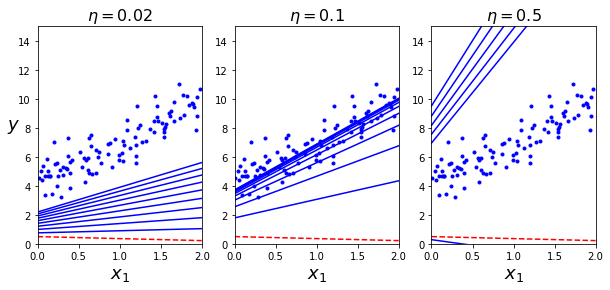

In [3]:
X_new = np.array([[0],[2]])
X_new_b = np.c_[np.ones((2, 1)), X_new]

print(X_new_b)

theta_path_bgd = []

def plot_gradient_descent(theta, eta, theta_path=None):
    m = len(X_b)
    plt.plot(X, y, "b.")
    n_iterations = 1000
    for iteration in range(n_iterations):
        if iteration < 10:
            y_predict = X_new_b.dot(theta)
            style = "b-" if iteration > 0 else "r--"
            plt.plot(X_new, y_predict, style)
        gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y)
        theta = theta - eta * gradients
        if theta_path is not None:
            theta_path.append(theta)
    plt.xlabel("$x_1$", fontsize=18)
    plt.axis([0, 2, 0, 15])
    plt.title(r"$\eta = {}$".format(eta), fontsize=16)

np.random.seed(42)
theta = np.random.randn(2,1)  # random initialization

plt.figure(figsize=(10,4))
plt.subplot(131); plot_gradient_descent(theta, eta=0.02)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.subplot(132); plot_gradient_descent(theta, eta=0.1, theta_path=theta_path_bgd)
plt.subplot(133); plot_gradient_descent(theta, eta=0.5)

plt.show()

在左面的那副图中，学习率是最小的，算法几乎不能求出最后的结果，而且还会花费大量的时间。在中间的这幅图中，学习率的表现看起来不错，仅仅几次迭代后，它就收敛到了最后的结果。在右面的那副图中，学习率太大了，算法是发散的，跳过了所有的训练样本，同时每一步都离正确的结果越来越远。

为了找到一个好的学习率，你可以使用`网格搜索`(详见第二章)。当然，你一般会限制迭代的次数，以便网格搜索可以消除模型需要很长时间才能收敛这一个问题。

你可能想知道如何选取迭代的次数。如果它太小了，当算法停止的时候，你依然没有找到最优解。如果它太大了，算法会非常的耗时同时后来的迭代参数也不会发生改变。一个简单的解决方法是：设置一个非常大的迭代次数，但是当梯度向量变得非常小的时候，结束迭代。非常小指的是：梯度向量小于一个值$\varepsilon$(称为`容差`)。这时候可以认为梯度下降几乎已经达到了最小值。

> **收敛速率**
> 
> 当损失函数是`凸函数`，同时它的斜率不能突变(就像均方差损失函数那样)，那么它的批量梯度下降算法固定学习率之后，它的收敛速率是$O(\frac{1}{iterations})$。换句话说，如果你将容差$\varepsilon$缩小10倍后(这样可以得到一个更精确的结果)，这个算法的迭代次数大约会变成原来的10倍

### 4.2.2 随机梯度下降
批量梯度下降的最要问题是计算每一步的梯度时都需要使用整个训练集，这导致在规模较大的数据集上，其会变得非常的慢。与其完全相反的随机梯度下降，在每一步的梯度计算上只随机选取训练集中的一个样本。很明显，由于每一次的操作都使用了非常少的数据，这样使得算法变得非常快。由于每一次迭代，只需要在内存中有一个实例，这使随机梯度算法可以在大规模训练集上使用。

另一方面，由于它的随机性，与批量梯度下降相比，其呈现出更多的不规律性：它到达最小值不是平缓的下降，损失函数会忽高忽低，只是在大体上呈下降趋势。随着时间的推移，它会非常的靠近最小值，但是它不会停止在一个值上，它会一直在这个值附近摆动(如`图4-9`)。因此，当算法停止的时候，最后的参数还不错，但不是最优值。

<img src="images/04_09.png" style="width:500px;"/>

当损失函数很不规则时((如`图4-6`)，随机梯度下降算法能够跳过局部最小值。因此，随机梯度下降在寻找全局最小值上比批量梯度下降表现要好。

虽然随机性可以很好的跳过局部最优值，但同时它却不能达到最小值。解决这个难题的一个办法是逐渐降低学习率。 开始时，走的每一步较大(这有助于快速前进同时跳过局部最小值)，然后变得越来越小，从而使算法到达全局最小值。 这个过程被称为`模拟退火`，因为它类似于熔融金属慢慢冷却的冶金学退火过程。 决定每次迭代的学习率的函数称为`learning schedule`。 如果学习速度降低得过快，你可能会陷入局部最小值，甚至在到达最小值的半路就停止了。 如果学习速度降低得太慢，你可能在最小值的附近长时间摆动，同时如果过早停止训练，最终只会出现次优解。

下面的代码使用一个简单的`learning schedule`来实现随机梯度下降：

In [4]:
n_epochs = 50
t0, t1 = 5, 50  #learning_schedule的超参数

def learning_schedule(t):
    return t0 / (t + t1)

theta = np.random.randn(2,1)

for epoch in range(n_epochs):
    for i in range(m):
        random_index = np.random.randint(m)
        xi = X_b[random_index:random_index+1]
        yi = y[random_index:random_index+1]
        gradients = 2 * xi.T.dot(xi.dot(theta)-yi)
        eta = learning_schedule(epoch * m + i)
        theta = theta - eta * gradients

按习惯来讲，我们进行$m$轮的迭代，每一轮迭代被称为`一代`。在整个训练集上，随机梯度下降迭代了1000次时，一般在第50次的时候就可以达到一个比较好的结果。

In [5]:
theta

array([[4.20742938],
       [2.74264448]])

下图展示了前10次的训练过程(*注意每一步的不规则程度*)：

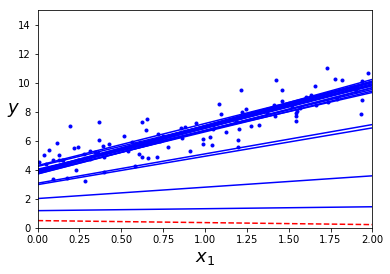

In [6]:
theta_path_sgd = []
m = len(X_b)
np.random.seed(42)

n_epochs = 50
t0, t1 = 5, 50  # learning schedule hyperparameters

def learning_schedule(t):
    return t0 / (t + t1)

theta = np.random.randn(2,1)  # random initialization

for epoch in range(n_epochs):
    for i in range(m):
        if epoch == 0 and i < 20:
            y_predict = X_new_b.dot(theta)
            style = "b-" if i > 0 else "r--"
            plt.plot(X_new, y_predict, style)
        random_index = np.random.randint(m)
        xi = X_b[random_index:random_index+1]
        yi = y[random_index:random_index+1]
        gradients = 2 * xi.T.dot(xi.dot(theta) - yi)
        eta = learning_schedule(epoch * m + i)
        theta = theta - eta * gradients
        theta_path_sgd.append(theta)

plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([0, 2, 0, 15])
plt.show()  

由于每个实例的选择是随机的，有的实例可能在每一代中都被选到，这样其他的实例也可能一直不被选到。如果你想保证每一代迭代过程，算法可以遍历所有实例，一种方法是将训练集打乱重排，然后选择一个实例，之后再继续打乱重排，以此类推一直进行下去。但是这样收敛速度会非常的慢。

通过使用`Scikit-Learn`完成线性回归的随机梯度下降，你需要使用`SGDRegressor`类，这个类默认优化的是`均方差损失函数`。下面的代码迭代了50代，其学习率$\eta$为0.1(`eta0=0.1`)，使用默认的`learning schedule`(与前面的不一样)，同时也没有添加任何正则项(`penalty = None`)：

In [7]:
sgd_reg = sklearn.linear_model.SGDRegressor(max_iter=50, tol=math.exp(-3), penalty=None, eta0=0.1) 
sgd_reg.fit(X, y.ravel())
sgd_reg.intercept_, sgd_reg.coef_

(array([4.12582149]), array([2.72827391]))

你可以再一次发现，这个结果非常的接近正规方程的解。

### 4.2.3 小批量梯度下降
最后一个梯度下降算法，我们将介绍小批量梯度下降算法。一旦你理解了批量梯度下降和随机梯度下降，再去理解小批量梯度下降是非常简单的。在迭代的每一步，批量梯度使用整个训练集，随机梯度时候用仅仅一个实例，在小批量梯度下降中，它则使用一个随机的小型实例集。它比随机梯度的主要优点在于你可以通过矩阵运算的硬件优化得到一个较好的训练表现，尤其当你使用GPU进行运算的时候。

小批量梯度下降在参数空间上的表现比随机梯度下降要好的多，尤其在有大量的小型实例集时。作为结果，小批量梯度下降会比随机梯度更靠近最小值。但是，另一方面，它有可能陷在局部最小值中(在遇到局部最小值问题的情况下，和我们之前看到的线性回归不一样)。 

In [8]:
theta_path_mgd = []

n_iterations = 50
minibatch_size = 20

np.random.seed(42)
theta = np.random.randn(2,1)  # random initialization

t0, t1 = 10, 1000
def learning_schedule(t):
    return t0 / (t + t1)

t = 0
for epoch in range(n_iterations):
    shuffled_indices = np.random.permutation(m)
    X_b_shuffled = X_b[shuffled_indices]
    y_shuffled = y[shuffled_indices]
    for i in range(0, m, minibatch_size):
        t += 1
        xi = X_b_shuffled[i:i+minibatch_size]
        yi = y_shuffled[i:i+minibatch_size]
        gradients = 2 * xi.T.dot(xi.dot(theta) - yi)
        eta = learning_schedule(t)
        theta = theta - eta * gradients
        theta_path_mgd.append(theta)
        
theta

array([[4.25214635],
       [2.7896408 ]])

`图4-11`显示了训练期间三种梯度下降算法在参数空间中所采用的路径。 他们都接近最小值，但批量梯度的路径最后停在了最小值，而随机梯度和小批量梯度最后都在最小值附近摆动。 但是，不要忘记，批次梯度需要花费大量时间来完成每一步，但是，如果你使用了一个较好的`learning schedule`，随机梯度和小批量梯度也可以得到最小值。

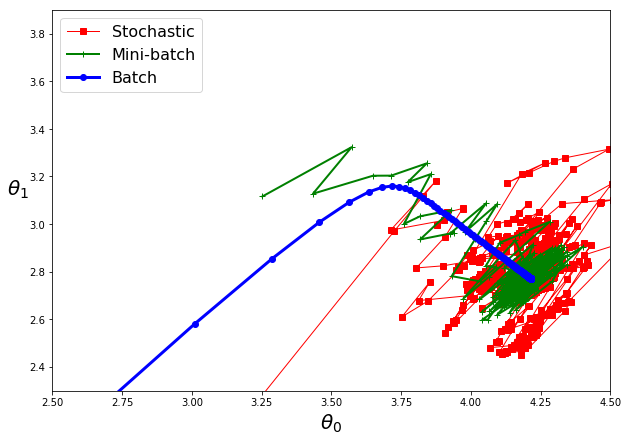

In [9]:
theta_path_bgd = np.array(theta_path_bgd)
theta_path_sgd = np.array(theta_path_sgd)
theta_path_mgd = np.array(theta_path_mgd)

plt.figure(figsize=(10,7))
plt.plot(theta_path_sgd[:, 0], theta_path_sgd[:, 1], "r-s", linewidth=1, label="Stochastic")
plt.plot(theta_path_mgd[:, 0], theta_path_mgd[:, 1], "g-+", linewidth=2, label="Mini-batch")
plt.plot(theta_path_bgd[:, 0], theta_path_bgd[:, 1], "b-o", linewidth=3, label="Batch")
plt.legend(loc="upper left", fontsize=16)
plt.xlabel(r"$\theta_0$", fontsize=20)
plt.ylabel(r"$\theta_1$   ", fontsize=20, rotation=0)
plt.axis([2.5, 4.5, 2.3, 3.9])
plt.show()

让我比较一下目前我们已经探讨过的对线性回归的梯度下降算法。如`表4-1`所示，其中`m`表示训练样本的个数，`n`表示特征的个数。

<img src="images/t04_01.png" style="width:600px;"/>

> 上述算法在完成训练后，得到的参数基本没什么不同，它们会得到非常相似的模型，最后会以一样的方式去进行预测

## 4.3 多项式回归
如果你的数据实际上比简单的直线更复杂呢？ 令人惊讶的是，你依然可以使用线性模型来拟合非线性数据。 一个简单的方法是对每个特征进行加权后作为新的特征，然后训练一个线性模型在这个扩展的特征集。 这种方法称为`多项式回归`。

让我们看一个例子。首先，我们根据一个简单的二次方程(并加上一些噪声，如`图4-12`)来生成一些非线性数据：

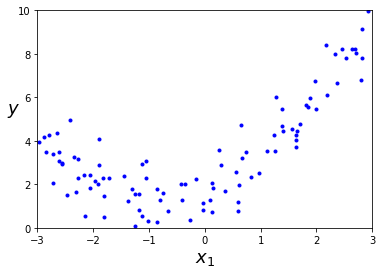

In [10]:
m = 100
np.random.seed(42)
X = 6 * np.random.rand(m, 1) - 3
y = 0.5 * X**2 + X + 2 + np.random.randn(m, 1)

plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([-3, 3, 0, 10])
plt.show()

很清楚的看出，直线不能恰当的拟合这些数据。于是，我们使用`Scikit-Learning`的`PolynomialFeatures`类进行训练数据集的转换，让训练集中每个特征的平方(2次多项式)作为新特征(在这个案例中仅存在一个特征)：

In [11]:
poly_features = sklearn.preprocessing.PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly_features.fit_transform(X)
X[0], X_poly[0]

(array([-0.75275929]), array([-0.75275929,  0.56664654]))

$X\_poly$现在包含原始特征$X$并加上了这个特征的平方$X^2$。现在你可以在这个扩展训练集上使用`LinearRegression`模型进行拟合，如`图4-13`：

In [12]:
lin_reg = sklearn.linear_model.LinearRegression()
lin_reg.fit(X_poly, y)
lin_reg.intercept_, lin_reg.coef_

(array([1.78134581]), array([[0.93366893, 0.56456263]]))

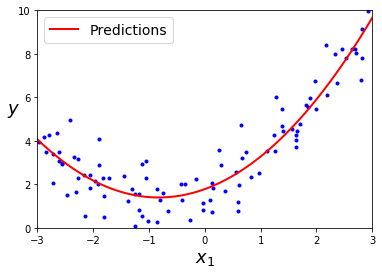

In [13]:
X_new=np.linspace(-3, 3, 100).reshape(100, 1)
X_new_poly = poly_features.transform(X_new)
y_new = lin_reg.predict(X_new_poly)
plt.plot(X, y, "b.")
plt.plot(X_new, y_new, "r-", linewidth=2, label="Predictions")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.legend(loc="upper left", fontsize=14)
plt.axis([-3, 3, 0, 10])
plt.show()

还是不错的，模型预测函数$\hat{y}=0.56x_1^2+0.93x_1+1.78$，事实上原始函数为$y=0.5x_1^2+1.0x_1+2.0+$。

请注意，当存在多个特征时，多项式回归能够找出特征之间的关系(这是普通线性回归模型无法做到的)。 这是因为`LinearRegression`会自动添加当前阶数下特征的所有组合。例如，如果有两个特征$a, b$，使用3阶(`degree=3`)的`LinearRegression`时，不仅有$a^2$, $a^3$, $b^2$以及$b^3$，同时也会有它们的其他组合项$ab$, $a^2b$, $ab^2$。

> `PolynomialFeatures(degree=d)`把一个包含$n$个特征的数组转换为一个包含$\frac{(n+d)!}{d!n!}$特征的数组，$n!$表示$n$的阶乘。小心大量特征的组合爆炸！



## 4.4 学习曲线
如果你使用一个高阶的多项式回归，你可能发现它的拟合程度要比普通的线性回归要好的多。例如，`图4-14`使用一个300阶的多项式模型去拟合之前的数据集，并同简单线性回归、二阶的多项式回归进行比较。注意300阶的多项式模型是如何摆动以尽可能接近训练实例。

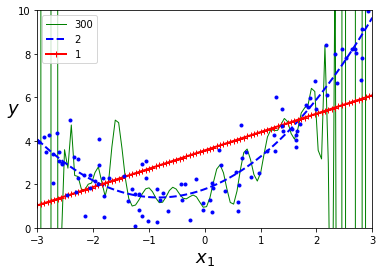

In [14]:
for style, width, degree in (("g-", 1, 300), ("b--", 2, 2), ("r-+", 2, 1)):
    polybig_features = sklearn.preprocessing.PolynomialFeatures(degree=degree, include_bias=False)
    std_scaler = sklearn.preprocessing.StandardScaler()
    lin_reg = sklearn.linear_model.LinearRegression()
    polynomial_regression = sklearn.pipeline.Pipeline((
            ("poly_features", polybig_features),
            ("std_scaler", std_scaler),
            ("lin_reg", lin_reg),
        ))
    polynomial_regression.fit(X, y)
    y_newbig = polynomial_regression.predict(X_new)
    plt.plot(X_new, y_newbig, style, label=str(degree), linewidth=width)

plt.plot(X, y, "b.", linewidth=3)
plt.legend(loc="upper left")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([-3, 3, 0, 10])
plt.show()

当然，这种高阶多项式回归模型在这个训练集上严重过拟合了，线性模型则欠拟合。在这个训练集上，二次模型有着较好的泛化能力。那是因为在生成数据时使用了二次模型，但是一般我们不知道这个数据生成函数是什么，那我们该如何决定我们模型的复杂度呢？你如何告诉我你的模型是过拟合还是欠拟合？

在第二章，你可以使用交叉验证来估计一个模型的泛化能力。如果一个模型在训练集上表现良好，通过交叉验证指标却得出其泛化能力很差，那么你的模型就是过拟合了。如果在这两方面都表现不好，那么它就是欠拟合了。这种方法可以告诉我们，你的模型是太复杂还是太简单了。

另一种方法是观察学习曲线：画出模型在训练集上的表现，同时画出以训练集规模为自变量的训练集函数。为了得到图像，需要在训练集的不同规模子集上进行多次训练。下面的代码定义了一个函数，用来画出给定训练集后的模型学习曲线：

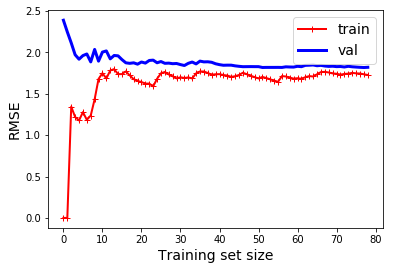

In [15]:
def plot_learning_curves(model, X, y):
    X_train, X_val, y_train, y_val = sklearn.model_selection.train_test_split(X, y, test_size=0.2, random_state=10)
    train_errors, val_errors = [], []
    for m in range(1, len(X_train)):
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(sklearn.metrics.mean_squared_error(y_train_predict, y_train[:m]))
        val_errors.append(sklearn.metrics.mean_squared_error(y_val_predict, y_val))

    plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="train")
    plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="val")
    plt.legend(loc="upper right", fontsize=14)   # not shown in the book
    plt.xlabel("Training set size", fontsize=14) # not shown
    plt.ylabel("RMSE", fontsize=14)              # not shown

lin_reg = sklearn.linear_model.LinearRegression() 
plot_learning_curves(lin_reg, X, y)
plt.show()

这幅图值得我们深究。首先，我们观察训练集的表现：当训练集只有一两个样本的时候，模型能够非常好的拟合它们，这也是为什么曲线是从零开始的原因。但是当加入了一些新的样本的时候，训练集上的拟合程度变得难以接受，出现这种情况有两个原因，一是因为数据中含有噪声，另一个是数据根本不是线性的。因此随着数据规模的增大，误差也会一直增大，直到达到高原地带并趋于稳定，在之后，继续加入新的样本，模型的平均误差不会变得更好或者更差。我们继续来看模型在验证集上的表现，当以非常少的样本去训练时，模型不能恰当的泛化，也就是为什么验证误差一开始是非常大的。当训练样本变多的到时候，模型学习的东西变多，验证误差开始缓慢的下降。但是一条直线不可能很好的拟合这些数据，因此最后误差会到达在一个高原地带并趋于稳定，最后和训练集的曲线非常接近。

上面的曲线表现了一个典型的欠拟合模型，两条曲线都到达高原地带并趋于稳定，并且最后两条曲线非常接近，同时误差值非常大。

> **提示**
> 
> 如果你的模型在训练集上是欠拟合的，添加更多的样本是没用的。你需要使用一个更复杂的模型或者找到更好的特征。

现在让我们看一个在相同数据上10阶多项式模型拟合的学习曲线：

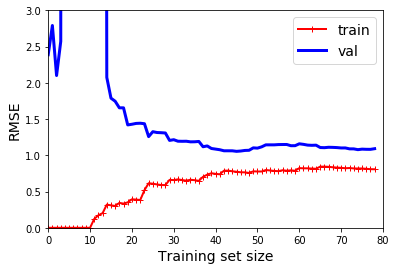

In [16]:
polynomial_regression = sklearn.pipeline.Pipeline((
        ("poly_features", sklearn.preprocessing.PolynomialFeatures(degree=10, include_bias=False)),
        ("lin_reg", sklearn.linear_model.LinearRegression()),
    ))

plot_learning_curves(polynomial_regression, X, y)
plt.axis([0, 80, 0, 3])           # not shown
plt.show()                        # not shown

这幅图像和之前的有一点点像，但是其有两个非常重要的不同点：
+ 在训练集上，误差要比线性回归模型低的多
+ 图中的两条曲线之间有间隔，这意味模型在训练集上的表现要比验证集上好的多，这也是模型过拟合的显著特点。当然，如果你使用了更大的训练数据，这两条曲线最后会非常的接近

> **提示**
> 
> 改善模型过拟合的一种方法是提供更多的训练数据，直到训练误差和验证误差相等。

> **偏差和方差的权衡**
> 
> 在统计和机器学习领域有个重要的理论：一个模型的泛化误差由三个不同误差的和决定：
> + 偏差：泛化误差的这部分误差是由于错误的假设决定的。例如实际是一个二次模型，你却假设了一个线性模型。一个高偏差的模型最容易出现欠拟合
> + 方差：这部分误差是由于模型对训练数据的微小变化较为敏感，一个多自由度的模型更容易有高的方差(例如一个高阶多项式模型)，因此会导致模型过拟合
> + 不可约误差：这部分误差是由于数据本身的噪声决定的。降低这部分误差的唯一方法就是进行数据清洗(例如：修复数据源，修复坏的传感器，识别和剔除异常值)
> 
> Increasing a model’s complexity will typically increase its variance and reduce its bias. Conversely, reducing a model’s complexity increases its bias and reduces its variance. This is why it is called a tradeoff.